In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict
from matplotlib.ticker import PercentFormatter

def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))

bdir = "../results/tables"
gt_data = pd.read_csv(bdir + "/all.gt_dist.table.txt", sep='\t')
inter_data = pd.read_csv(bdir + "/all.intersect.table.txt", sep='\t')
neigh_data = pd.read_csv(bdir + "/all.neighbor.table.txt", sep='\t')
svtype_data = pd.read_csv(bdir + "/all.svtype.table.txt", sep='\t')

tr_gt_data = pd.read_csv(bdir + "/tr.gt_dist.table.txt", sep='\t')
tr_inter_data = pd.read_csv(bdir + "/tr.intersect.table.txt", sep='\t')
tr_neigh_data = pd.read_csv(bdir + "/tr.neighbor.table.txt", sep='\t')
tr_svtype_data = pd.read_csv(bdir + "/tr.svtype.table.txt", sep='\t')

ntr_gt_data = pd.read_csv(bdir + "/non_tr.gt_dist.table.txt", sep='\t')
ntr_inter_data = pd.read_csv(bdir + "/non_tr.intersect.table.txt", sep='\t')
ntr_neigh_data = pd.read_csv(bdir + "/non_tr.neighbor.table.txt", sep='\t')
ntr_svtype_data = pd.read_csv(bdir + "/non_tr.svtype.table.txt", sep='\t')

# Overview Table

In [2]:
inter_data['Filtered'] = 0
add_summary(inter_data, True)

In [3]:
view = inter_data[(inter_data['experiment'] == 'tm')
                 & (inter_data['coverage'] == '32x')]

In [4]:
view.groupby(['program'])[['GT Concordance', 'TP-base', 'TP-comp', 'FP', 'FN', 'precision', 'recall', 'f1']].mean()

,GT Concordance,TP-base,TP-comp,FP,FN,precision,recall,f1
program,,,,,,,,
cutesv,0.127859,22927.808511,22981.404255,104494.978723,1051.468085,0.180129,0.956104,0.303015
kanpig,0.866194,22671.319149,21640.234043,597.851064,1129.340426,0.973004,0.952527,0.962648
sniffles,0.122663,24885.702128,24985.723404,121393.510638,762.553191,0.170554,0.970223,0.290001
svjedi,0.428069,25153.063830,25316.553191,19514.553191,326.978723,0.564100,0.987122,0.717764


In [5]:
# Sup Table stratifications

add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)
a = svtype_data[(svtype_data['experiment'] == 'tm')].copy()
a['TR'] = 'all'

b = tr_svtype_data[(tr_svtype_data['experiment'] == 'tm')].copy()
b['TR'] = 'within'

c = ntr_svtype_data[(ntr_svtype_data['experiment'] == 'tm')].copy()
c['TR'] = 'outside'

view = pd.concat([a, b, c])
sup_table = (view.groupby(['program', 'coverage', 'svtype', 'TR'])['GT Concordance'].describe()[['mean', 'std']].reset_index())

program_order = ['kanpig', 'svjedi', 'sniffles', 'cutesv']
coverage_order = ['32x', '16x', '8x']
svtype_order = ['TOT', 'DEL', 'INS']
TR_order = ['all', 'outside', 'within']

# Convert each column to a categorical type with the specified order
sup_table['program'] = pd.Categorical(sup_table['program'], categories=program_order, ordered=True)
sup_table['coverage'] = pd.Categorical(sup_table['coverage'], categories=coverage_order, ordered=True)
sup_table['svtype'] = pd.Categorical(sup_table['svtype'], categories=svtype_order, ordered=True)
sup_table['TR'] = pd.Categorical(sup_table['TR'], categories=TR_order, ordered=True)
sup_table.sort_values(by=['program', 'coverage', 'svtype', 'TR'], inplace=True)
sup_table.to_csv("SupTable_TM_GTconcordance.txt", sep='\t', index=False)

Again, kanpig had the highest genotype concordance at 84.9% followed by svjedi at 55.4%, cutesv at 34.1% and sniffles at 33.8%. Furthermore, the programs present SV f1 score (harmonic mean of precision and recall) was 0.948 for kanpig, 0.817 for svjedi, 0.611 for cutesv, and 0.605 for sniffles. Details of genotyper performance on multi-sample discovered SVs are available in

In [6]:
# Disc multi
view = inter_data[(inter_data['experiment'] == 'dm')
                 & (inter_data['coverage'] == '32x')]
view.groupby(['program'])[['gt_concordance', 'TP-base', 'TP-comp', 'FP', 'FN', 'precision', 'recall', 'f1']].mean()

,gt_concordance,TP-base,TP-comp,FP,FN,precision,recall,f1
program,,,,,,,,
cutesv,0.341779,22546.255319,21116.851064,25862.617021,914.553191,0.448934,0.961029,0.611791
kanpig,0.849293,21571.489362,20316.702128,1022.723404,1246.021277,0.951864,0.945392,0.948604
sniffles,0.338679,24040.936170,22542.808511,28567.361702,808.744681,0.440539,0.967418,0.605217
svjedi,0.554398,22781.702128,21367.085106,8809.659574,751.106383,0.707312,0.968049,0.817278


In [7]:
view = inter_data[(inter_data['experiment'] == 'dm')
                  & ((inter_data['program'] != "orig") | (inter_data['coverage'] == '32x'))
                 ]
view2 = view.groupby(['program', 'coverage'])[['gt_concordance', 'TP-base', 'TP-comp', 'FN', 'FP', 'precision', 'recall', 'f1']].mean()

In [8]:
view2.reset_index(inplace=True)
program_order = ['orig', 'kanpig', 'svjedi', 'sniffles', 'cutesv']
coverage_order = ['32x', '16x', '8x']
svtype_order = ['TOT', 'DEL', 'INS']
TR_order = ['all', 'outside', 'within']

view2['program'] = pd.Categorical(view2['program'], categories=program_order, ordered=True)
view2['coverage'] = pd.Categorical(view2['coverage'], categories=coverage_order, ordered=True)
view2.sort_values(by=['program', 'coverage'], inplace=True)
view2.to_csv("SupTable_DM_PrecisionRecall.txt", sep='\t', index=False)

# Genotype Distribution

In [9]:
import joblib
b = joblib.load("/Users/english/code/kanpig_experiments/manuscript/explore_section09/gtcnts.jl")
mean = np.sum(b, axis=1)
mean[0] = mean[3]
mean[3] = 0
mean = mean[:4]

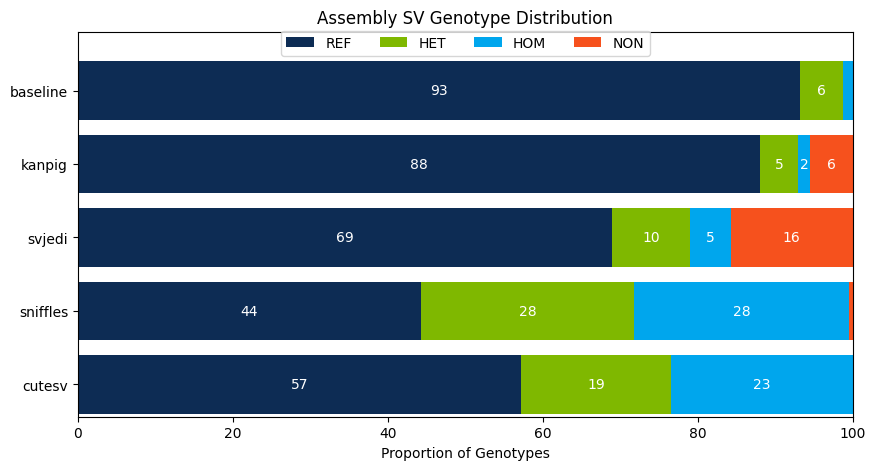

In [10]:
tests = ['cutesv', 'sniffles', 'svjedi', 'kanpig', 'baseline']

m_data = OrderedDict()

# Bottom up order
view = gt_data[(gt_data['coverage'] == '32x') 
               & (gt_data['technology'] == 'pac')
              & (gt_data['experiment'].isin(['tm', 'truth']))]
for i in tests:
    m_data[(i, 'pac')] = view[view['program'] == i][['REF', 'HET', 'HOM', 'NON']].sum()

m_data[('baseline', 'pac')] = mean
#data[('exbaseline', '')] = [17937331 , 1079127, 233567, 0]

# Normalize the data by percentages for each test and observation
normalized_data = OrderedDict()
y_labels = []
y_super = []
for key, counts in m_data.items():
    total = np.sum(counts)
    normalized_data[key] = (counts / total) * 100

    y_labels.append(key[0])
    if key[1] not in y_super:
        y_super.append(key[1])

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = .6
y_positions = []

# Define colors for each category
colors = ['#0D2C54', '#7FB800', '#00A6ED', '#F6511D']
categories = ['REF', 'HET', 'HOM', 'NON']

# Plot each test and observation
y_pos = -.75
for i, ((test, observation), counts) in enumerate(normalized_data.items()):
    y_pos += .75
    y_positions.append(y_pos)
    left = 0
    for j, (count, color, category) in enumerate(zip(counts, colors, categories)):
        ax.barh(y_pos, count, left=left, color=color, height=bar_width, label=category if y_pos == 0 else "")
        if count > 1.5:  # Only add text if the percentage is greater than 5
            ax.text(left + count / 2, y_pos, f'{count:.0f}', va='center', ha='center', color='white')
        left += count

# Adding labels and title
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)
ax.set_ylim((-.33, max(y_positions) + .6))
ax.set_xlabel('Proportion of Genotypes')
ax.set_title('Assembly SV Genotype Distribution')

# Adjusting the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(categories)], labels[:len(categories)], 
          loc="upper center", bbox_to_anchor=(0.5, 1.021), ncol=len(categories))
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../figure3/AsmGTDist.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [11]:
pd.DataFrame(normalized_data)

,cutesv,sniffles,svjedi,kanpig,baseline
,pac,pac,pac,pac,pac
REF,57.214676,44.231856,68.926018,88.046906,93.180819
HET,19.301544,27.542972,10.010251,4.881292,5.605847
HOM,23.483781,27.760796,5.304779,1.534727,1.213333
NON,0.000000,0.464376,15.758952,5.537075,0.000000


In [12]:
import joblib
b = joblib.load("/Users/english/code/kanpig_experiments/manuscript/analysis/disc_multi/gtcnts.jl")
mean = np.sum(b, axis=1)
mean[0] = mean[3]
mean[3] = 0
mean = mean[:4]

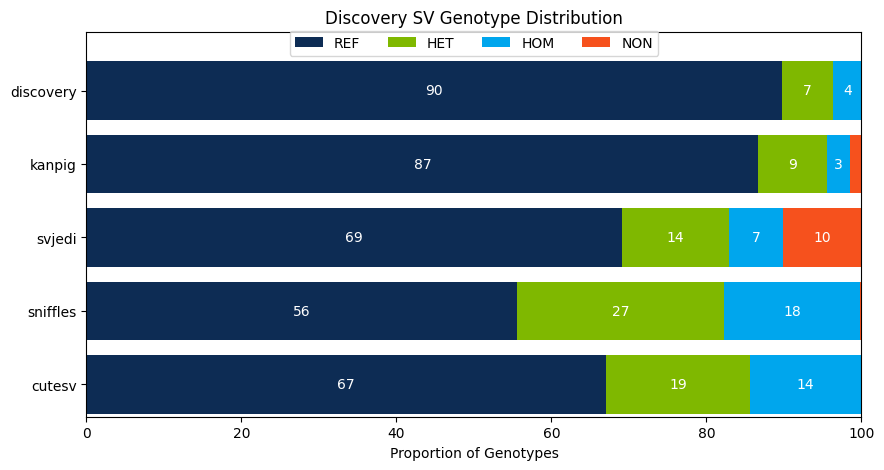

In [13]:
tests = ['cutesv', 'sniffles', 'svjedi', 'kanpig', 'discovery']

m_data = OrderedDict()

# Bottom up order
view = gt_data[(gt_data['coverage'] == '32x') 
               & (gt_data['technology'] == 'pac')
              & (gt_data['experiment'].isin(['dm']))]
for i in tests:
    m_data[(i, 'pac')] = view[view['program'] == i][['REF', 'HET', 'HOM', 'NON']].sum()

m_data[('discovery', 'pac')] = mean
#data[('exbaseline', '')] = [17937331 , 1079127, 233567, 0]

# Normalize the data by percentages for each test and observation
normalized_data = OrderedDict()
y_labels = []
y_super = []
for key, counts in m_data.items():
    total = np.sum(counts)
    normalized_data[key] = (counts / total) * 100

    y_labels.append(key[0])
    if key[1] not in y_super:
        y_super.append(key[1])

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = .6
y_positions = []

# Define colors for each category
colors = ['#0D2C54', '#7FB800', '#00A6ED', '#F6511D']
categories = ['REF', 'HET', 'HOM', 'NON']

# Plot each test and observation
y_pos = -.75
for i, ((test, observation), counts) in enumerate(normalized_data.items()):
    y_pos += .75
    y_positions.append(y_pos)
    left = 0
    for j, (count, color, category) in enumerate(zip(counts, colors, categories)):
        ax.barh(y_pos, count, left=left, color=color, height=bar_width, label=category if y_pos == 0 else "")
        if count > 1.5:  # Only add text if the percentage is greater than 5
            ax.text(left + count / 2, y_pos, f'{count:.0f}', va='center', ha='center', color='white')
        left += count

# Adding labels and title
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)
ax.set_ylim((-.33, max(y_positions) + .6))
ax.set_xlabel('Proportion of Genotypes')
ax.set_title('Discovery SV Genotype Distribution')

# Adjusting the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(categories)], labels[:len(categories)], 
          loc="upper center", bbox_to_anchor=(0.5, 1.021), ncol=len(categories))
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../figure3/DiscGTDist.pdf", format='pdf', bbox_inches='tight')
plt.show()


# Number of Neighbors

In [14]:
import pysam
import truvari
v = pysam.VariantFile("../explore_section09/local_test/dipcall_bcftools_merge_neigh.vcf.gz")
all_neigh = []
for entry in v:
    if entry.chrom in ['chrX', 'chrY']:
        continue
    sz = truvari.entry_size(entry)
    if sz < 50 or sz > 10000:
        continue
    n = entry.info['NumNeighbors']
    all_neigh.append(min(n, 10))
    
from collections import Counter
cnt = Counter(all_neigh)
cnt = pd.DataFrame([cnt]).T.reset_index()
cnt.columns = ['num_neigh', 'count']
cnt['percent of calls'] = cnt['count'] / cnt['count'].sum()
cnt.sort_values(by=['num_neigh'], inplace=True)

tot = cnt['count'].sum()
tot, tot - cnt.iloc[0]['count'], 1 - (cnt.iloc[0]['count'] / tot)

(403031, 371771.0, 0.922437728115207)

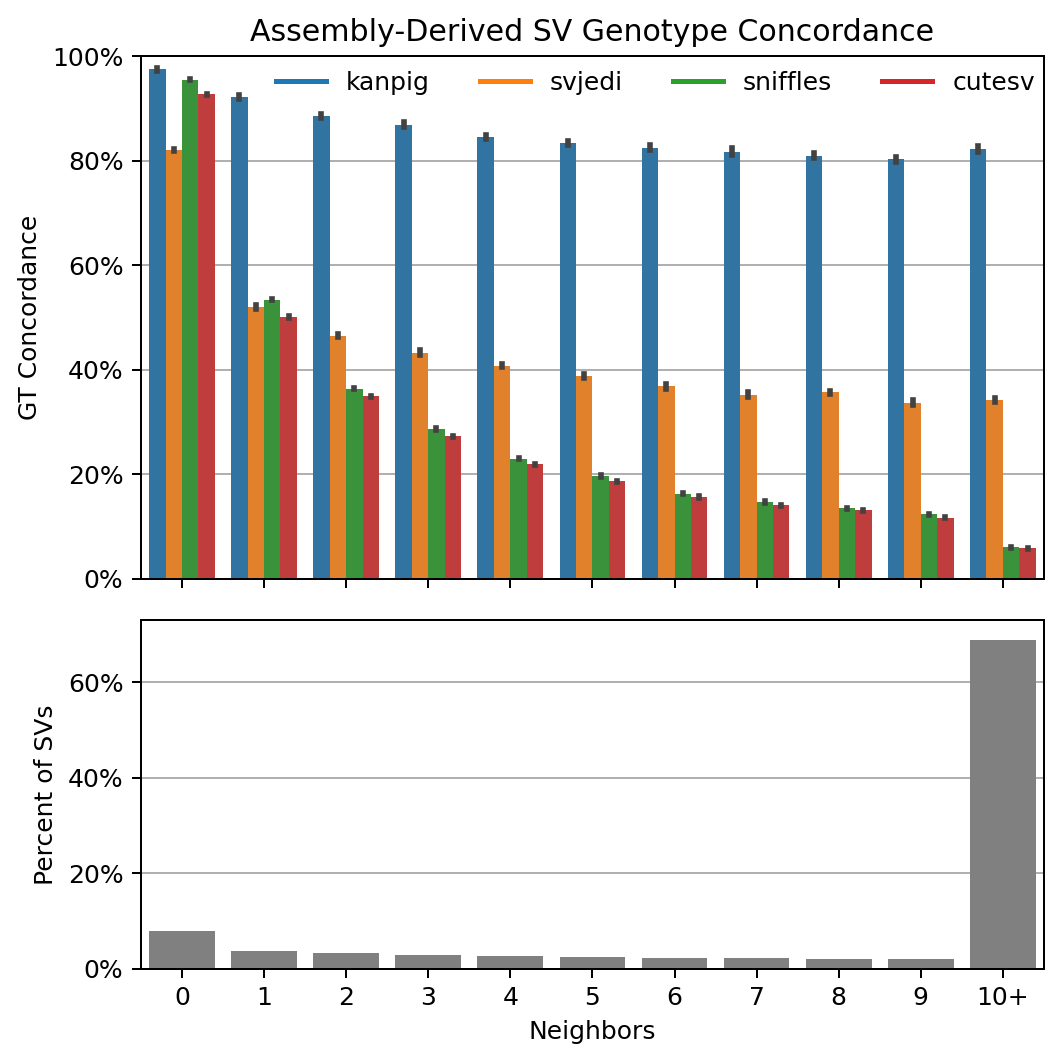

In [15]:
add_summary(neigh_data)

yvar = "GT Concordance"
experiment = "tm"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6), dpi=180,
                              gridspec_kw={'height_ratios': [3, 2]})  # figsize is (width, height)

view = neigh_data[(neigh_data['experiment'] == experiment) 
                  & (neigh_data['technology'] == 'pac')
                 & (neigh_data['coverage'] == '32x')]
lineplot = sb.barplot(data=view, ax=ax1,
                       x="num_neigh", y=yvar, 
                       hue="program",
                      hue_order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                     zorder=2)
ax1.set_ylim((0,1.0))
lineplot.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
hue_labels = ['kanpig', 'svjedi', 'sniffles', 'cutesv']
#styles = ['solid', 'dashed']
#style_labels = neigh_data['Technology'].unique()

# Get handles and labels for both hue and style
handles, _ = lineplot.get_legend_handles_labels()

# Create legend elements
hue_elements = [plt.Line2D([0], [0], color=sb.color_palette()[i], lw=2) for i in range(len(hue_labels))]
#style_elements = [plt.Line2D([0], [0], color='black', linestyle=styles[i], lw=2) for i in range(len(style_labels))]

# Combine elements
legend_elements = hue_elements #+ style_elements
legend_labels = list(hue_labels) #+ list(style_labels)

lineplot.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
lineplot.set_xticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"])
lineplot.set(title="Assembly-Derived SV Genotype Concordance", 
             xlabel="", 
             ylabel="GT Concordance")
# Create custom legend
ax1.legend(legend_elements, legend_labels, title='', ncol=4, loc='upper right', 
           bbox_to_anchor=(1.015, 1.015), frameon=False)
ax1.grid(axis='y', zorder=1)

hist = sb.barplot(data=cnt, x="num_neigh", y="percent of calls", zorder=2, color='#808080')
hist.set(ylabel="Percent of SVs", xlabel="Neighbors")
hist.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax2.grid(axis='y', zorder=1)
ax2.set(ylim=(0,0.73))
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../figure3/AsmNeigh.pdf", format='pdf', bbox_inches='tight')
fig.tight_layout()

In [16]:
view = neigh_data[(neigh_data['experiment'] == 'tm') 
                  & (neigh_data['technology'] == 'pac')
                 & (neigh_data['coverage'] == '32x')]
new_parts = []
for _, i in view.groupby(['sample', 'program']):
    rest = i[i['num_neigh'] >= 1]
    rest_sum = rest[['Concordant', 'Discordant', 'Missing', 'Filtered', "TP", "FP", "TN", "FN"]].sum()

    half = i[i['num_neigh'] < 1][list(rest_sum.index) + ['num_neigh']].copy()

    rest_sum['num_neigh'] = 1
    rest_sum['sample'] = _[0]
    rest_sum['program'] = _[1]

    
    half['sample'] = _[0]
    half['program'] = _[1]
    
    new_row = pd.concat([half, rest_sum.to_frame().T])
    
    new_parts.append(new_row)

view2 = pd.concat(new_parts)
add_summary(view2)
view2.groupby(['program', 'num_neigh'])['GT Concordance'].mean().unstack()

num_neigh,0,1
program,,
cutesv,0.926533,0.096913
kanpig,0.975031,0.838398
sniffles,0.954806,0.095305
svjedi,0.82011,0.37357


In [17]:
import pysam
import truvari
v = pysam.VariantFile("disc_multi/sniffles_truvari_collapse_ccs_filtered_neigh.vcf.gz")
all_neigh = []
for entry in v:
    if entry.chrom in ['chrX', 'chrY']:
        continue
    sz = truvari.entry_size(entry)
    if sz < 50 or sz > 10000:
        continue
    n = entry.info['NumNeighbors']
    all_neigh.append(min(n, 10))
    
from collections import Counter
cnt = Counter(all_neigh)
cnt = pd.DataFrame([cnt]).T.reset_index()
cnt.columns = ['num_neigh', 'count']
cnt['percent of calls'] = cnt['count'] / cnt['count'].sum()
cnt.sort_values(by=['num_neigh'], inplace=True)

tot = cnt['count'].sum()
tot, tot - cnt.iloc[0]['count'], 1 - (cnt.iloc[0]['count'] / tot)

[E::idx_find_and_load] Could not retrieve index file for 'disc_multi/sniffles_truvari_collapse_ccs_filtered_neigh.vcf.gz'


(243719, 202729.0, 0.8318145076912346)

In [18]:
view = neigh_data[(neigh_data['experiment'] == 'dm') 
                  & (neigh_data['technology'] == 'pac')
                 & (neigh_data['coverage'] == '32x')]
new_parts = []
for _, i in view.groupby(['sample', 'program']):
    rest = i[i['num_neigh'] >= 1]
    rest_sum = rest[['Concordant', 'Discordant', 'Missing', 'Filtered', "TP", "FP", "TN", "FN"]].sum()

    half = i[i['num_neigh'] < 1][list(rest_sum.index) + ['num_neigh']].copy()

    rest_sum['num_neigh'] = 1
    rest_sum['sample'] = _[0]
    rest_sum['program'] = _[1]

    
    half['sample'] = _[0]
    half['program'] = _[1]
    
    new_row = pd.concat([half, rest_sum.to_frame().T])
    
    new_parts.append(new_row)

view2 = pd.concat(new_parts)
add_summary(view2)
view2.groupby(['program', 'num_neigh'])['GT Concordance'].mean().unstack()

num_neigh,0,1
program,,
cutesv,0.851097,0.239006
kanpig,0.879018,0.832436
sniffles,0.863389,0.244566
svjedi,0.756449,0.471096


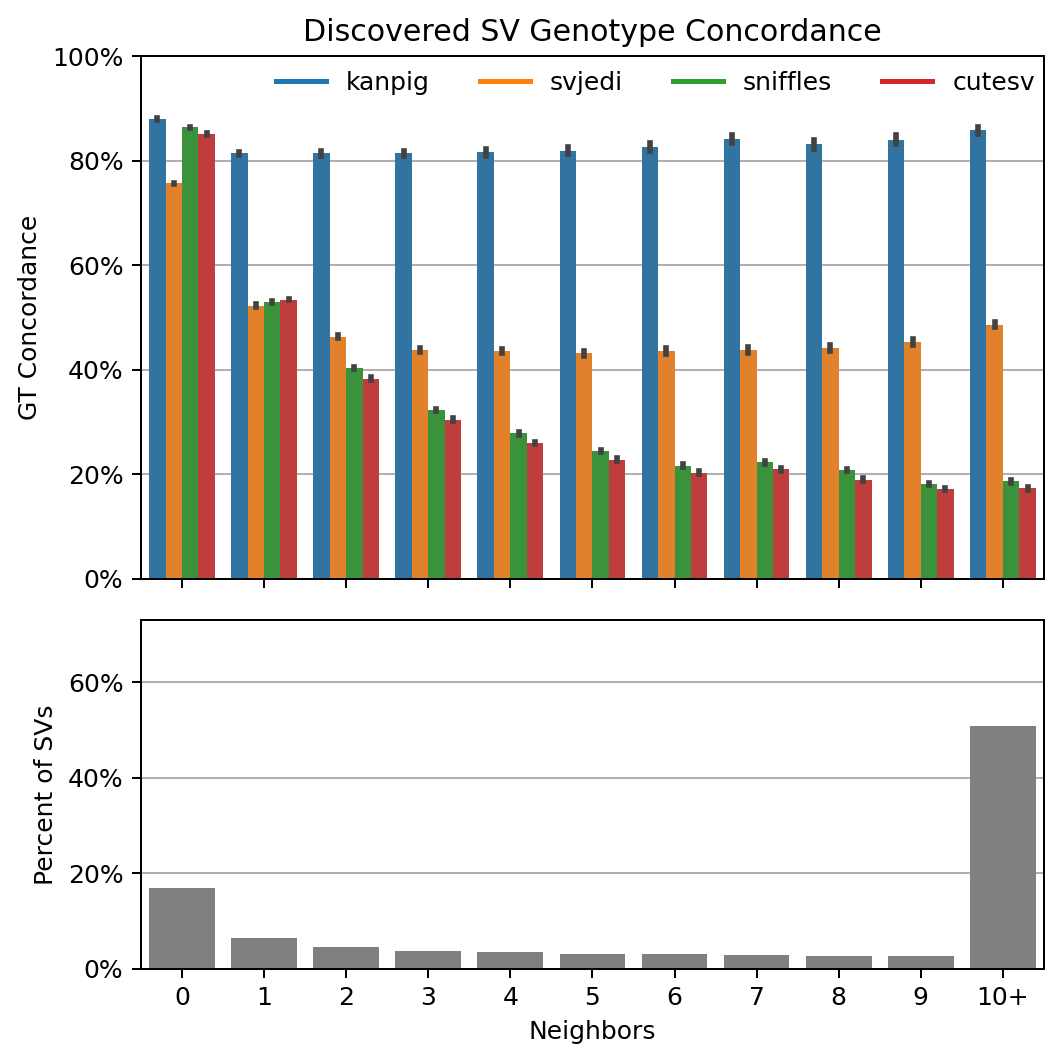

In [19]:
add_summary(neigh_data)

yvar = "GT Concordance"
experiment = "dm"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6), dpi=180,
                              gridspec_kw={'height_ratios': [3, 2]})  # figsize is (width, height)

view = neigh_data[(neigh_data['experiment'] == experiment) 
                  & (neigh_data['technology'] == 'pac')
                 & (neigh_data['coverage'] == '32x')]
lineplot = sb.barplot(data=view, ax=ax1,
                       x="num_neigh", y=yvar, 
                       hue="program",
                      hue_order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                     zorder=2)
lineplot.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax1.set(ylim=(0,1.0))

hue_labels = ['kanpig', 'svjedi', 'sniffles', 'cutesv']
#styles = ['solid', 'dashed']
#style_labels = neigh_data['Technology'].unique()

# Get handles and labels for both hue and style
handles, _ = lineplot.get_legend_handles_labels()

# Create legend elements
hue_elements = [plt.Line2D([0], [0], color=sb.color_palette()[i], lw=2) for i in range(len(hue_labels))]
#style_elements = [plt.Line2D([0], [0], color='black', linestyle=styles[i], lw=2) for i in range(len(style_labels))]

# Combine elements
legend_elements = hue_elements #+ style_elements
legend_labels = list(hue_labels) #+ list(style_labels)

lineplot.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
lineplot.set_xticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"])
lineplot.set(title="Discovered SV Genotype Concordance", 
             xlabel="", 
             ylabel="GT Concordance")
# Create custom legend
ax1.legend(legend_elements, legend_labels, title='', ncol=4, loc='upper right', 
           bbox_to_anchor=(1.015, 1.015), frameon=False)
ax1.grid(axis='y', zorder=1)

hist = sb.barplot(data=cnt, x="num_neigh", y="percent of calls", zorder=2, color='#808080')
hist.set(ylabel="Percent of SVs", xlabel="Neighbors")
hist.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax2.grid(axis='y', zorder=1)
ax2.set(ylim=(0,0.73))
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../figure3/DiscNeigh.pdf", format='pdf', bbox_inches='tight')
fig.tight_layout()

# Overall Plot

In [20]:
YMIN,YMAX = 0,1
def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing', 'Filtered']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))
    
def plot_gtconcordance_barplot(subset, ax, title="Genotype Concordance"):
    p = sb.barplot(data=subset, x="program", y="GT Concordance", hue="coverage", 
                   hue_order=['32x', '16x', '8x'], ax=ax, zorder=2)
    p.set(title=title, ylabel="Overall GT Concordance")

    categories = subset['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YMIN, YMAX)
    ax.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='Coverage', loc='upper right')
    legend.get_frame().set_edgecolor('white')
    
def plot_typestrat(subset_a, subset_b, ax1, ax2):
    """
    A is TRs, B is Non-TRs
    """
    p = sb.barplot(data=subset_a, x="program", y="GT Concordance", hue="svtype", 
                   hue_order=['DEL', 'INS'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax1)


    categories = subset_a['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YMIN, YMAX)
    ax1.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='SV Type', ncol=1, loc='upper right')
    legend.get_frame().set_edgecolor('white')
    ax1.set(ylabel="SVTYPE GT Concordance")

    ## Second half
    p = sb.barplot(data=subset_b, x="program", y="GT Concordance", hue="TR", 
                   hue_order=['inside', 'outside'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax2)


    p.set(xlabel="Program", ylabel="TR GT Concordance")

    categories = subset_a['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YMIN, YMAX)
    ax2.grid(axis='y', zorder=1)
    #legend = p.legend(frameon=True, title='SV Type', loc='upper right')
    #legend.get_frame().set_edgecolor('white')
    


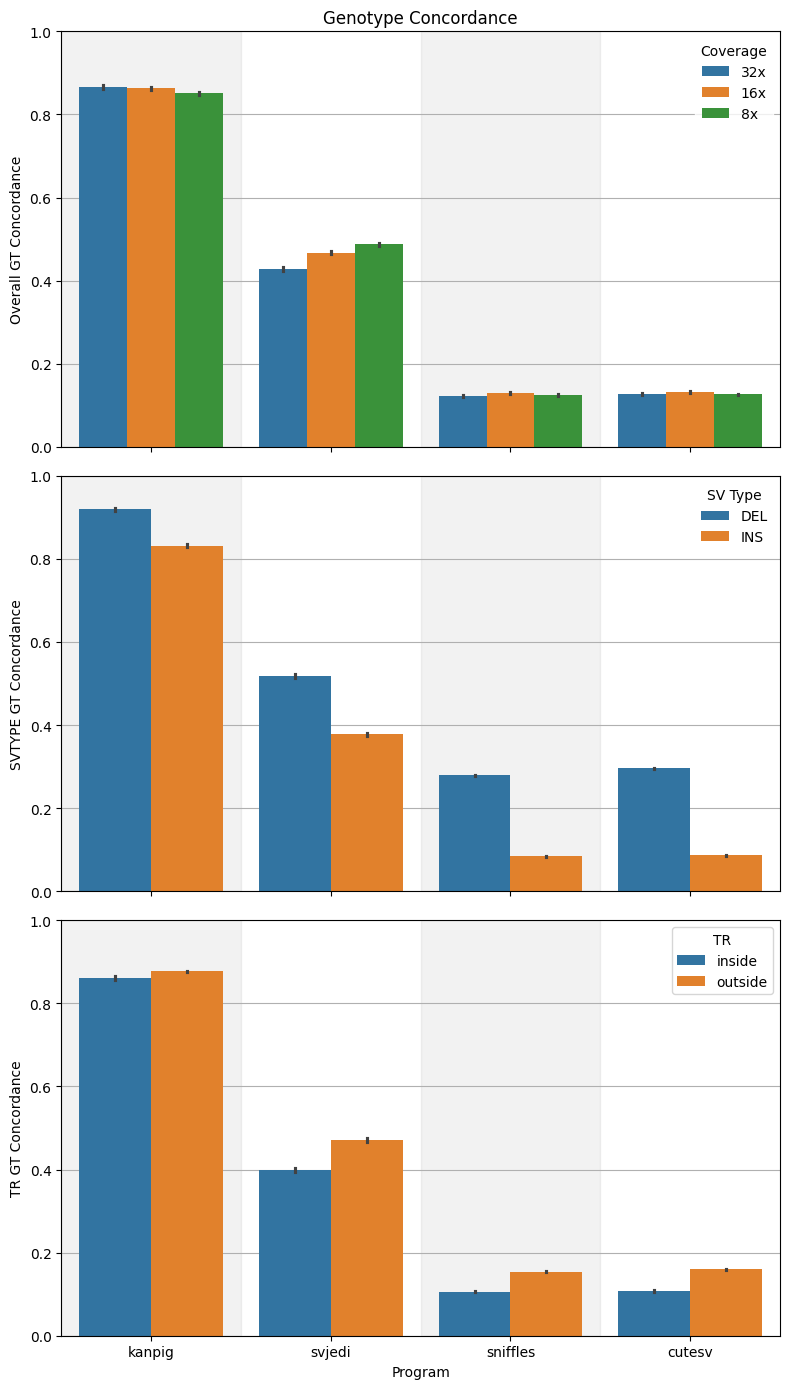

In [21]:
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

exp = 'tm'

view = svtype_data[(svtype_data['svtype'] == 'TOT')
                    & (svtype_data['experiment'] == exp)
                    & (svtype_data['technology'] == 'pac')]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

plot_gtconcordance_barplot(view, ax1, "Genotype Concordance")

a = svtype_data[(tr_svtype_data['svtype'] != 'TOT')
                   & (svtype_data['experiment'] == exp)
                   & (svtype_data['technology'] == 'pac')
                   & (svtype_data['coverage'] == '32x')]

b = tr_svtype_data[(tr_svtype_data['svtype'] == 'TOT')
                   & (tr_svtype_data['experiment'] == exp)
                   & (tr_svtype_data['technology'] == 'pac')
                   & (tr_svtype_data['coverage'] == '32x')].copy()
b['TR'] = 'inside'
c = ntr_svtype_data[(ntr_svtype_data['svtype'] == 'TOT')
                   & (ntr_svtype_data['experiment'] == exp)
                   & (ntr_svtype_data['technology'] == 'pac')
                   & (ntr_svtype_data['coverage'] == '32x')].copy()
c['TR'] = 'outside'
d = pd.concat([b, c])

plot_typestrat(a, d, ax2, ax3)
fig.tight_layout()
plt.show()


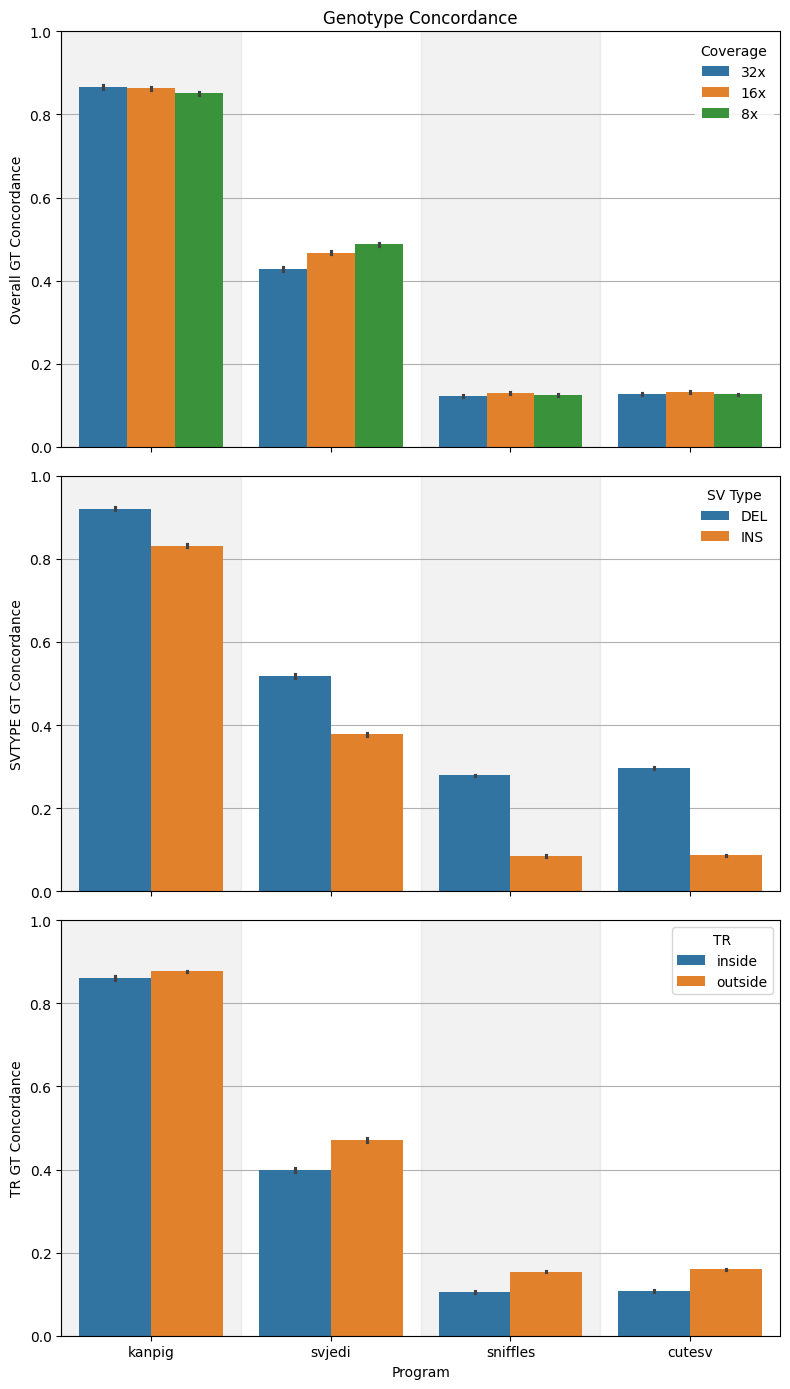

In [22]:
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

exp = 'tm'

view = svtype_data[(svtype_data['svtype'] == 'TOT')
                    & (svtype_data['experiment'] == exp)
                    & (svtype_data['technology'] == 'pac')]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

plot_gtconcordance_barplot(view, ax1, "Genotype Concordance")

a = svtype_data[(tr_svtype_data['svtype'] != 'TOT')
                   & (svtype_data['experiment'] == exp)
                   & (svtype_data['technology'] == 'pac')
                   & (svtype_data['coverage'] == '32x')]

b = tr_svtype_data[(tr_svtype_data['svtype'] == 'TOT')
                   & (tr_svtype_data['experiment'] == exp)
                   & (tr_svtype_data['technology'] == 'pac')
                   & (tr_svtype_data['coverage'] == '32x')].copy()
b['TR'] = 'inside'
c = ntr_svtype_data[(ntr_svtype_data['svtype'] == 'TOT')
                   & (ntr_svtype_data['experiment'] == exp)
                   & (ntr_svtype_data['technology'] == 'pac')
                   & (ntr_svtype_data['coverage'] == '32x')].copy()
c['TR'] = 'outside'
d = pd.concat([b, c])

plot_typestrat(a, d, ax2, ax3)
fig.tight_layout()
plt.show()
